# Load Convolutional Neural Network


### Import Packages


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis

## Load Saved Model

In [2]:
new_model = tf.keras.models.load_model(r"../../trained_models/cnn_main_50.keras")
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 16)            64        
                                                                 
 batch_normalization (BatchN  (None, 14, 16)           64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 14, 16)            0         
                                                                 
 dropout (Dropout)           (None, 14, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            1568      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 32)           128       
 hNormalization)                                        

## Load Lunar Training Data


In [3]:
lunar_train_dir = r"../../data/lunar/test/data/S12_GradeB/"
events = [file for file in os.listdir(lunar_train_dir) if file.endswith(".csv")]
num_of_events = len(events)
event = [i for i in range(1)]  # num_of_events
print("Events: ", events)
print("Number of events: ", num_of_events)
print("Events Considered: ", event)

Events:  ['xa.s12.00.mhz.1969-12-16HR00_evid00006.csv', 'xa.s12.00.mhz.1970-01-09HR00_evid00007.csv', 'xa.s12.00.mhz.1970-02-07HR00_evid00014.csv', 'xa.s12.00.mhz.1970-02-18HR00_evid00016.csv', 'xa.s12.00.mhz.1970-03-14HR00_evid00018.csv', 'xa.s12.00.mhz.1970-03-30HR00_evid00020.csv', 'xa.s12.00.mhz.1970-04-03HR00_evid00021.csv', 'xa.s12.00.mhz.1970-05-20HR00_evid00026.csv', 'xa.s12.00.mhz.1970-05-23HR00_evid00027.csv', 'xa.s12.00.mhz.1970-05-24HR00_evid00028.csv', 'xa.s12.00.mhz.1970-05-25HR00_evid00029.csv', 'xa.s12.00.mhz.1970-06-19HR00_evid00031.csv', 'xa.s12.00.mhz.1970-07-17HR00_evid00035.csv', 'xa.s12.00.mhz.1970-07-18HR00_evid00036.csv', 'xa.s12.00.mhz.1970-07-20HR00_evid00037.csv', 'xa.s12.00.mhz.1970-07-27HR00_evid00039.csv', 'xa.s12.00.mhz.1970-09-09HR00_evid00043.csv', 'xa.s12.00.mhz.1970-10-26HR00_evid00049.csv', 'xa.s12.00.mhz.1970-11-03HR00_evid00050.csv', 'xa.s12.00.mhz.1970-11-03HR00_evid00051.csv', 'xa.s12.00.mhz.1971-01-03HR00_evid00057.csv', 'xa.s12.00.mhz.1971-01-0

## Data Preparation


In [4]:
lens_array = []
time_arrays = []
data_arrays = []
for file in events:
    file = lunar_train_dir + file
    df = pd.read_csv(file)

    lens_array.append(len(df))

    t = df["time_rel(sec)"].values
    time_arrays.append(t)

    X = df["velocity(m/s)"].values
    X_standard = (X - np.mean(X)) / np.std(X)
    data_arrays.append(X_standard)


time_array = np.concatenate(time_arrays)
time = pd.DataFrame(time_array, columns=["time_rel(sec)"])

data_array = np.concatenate(data_arrays)
seismic_data = pd.DataFrame(data_array, columns=["velocity(m/s)"])

In [5]:
X_standard = seismic_data["velocity(m/s)"].values
X_standard = X_standard.astype(np.float32)  # To save memory

In [6]:
windows_size = 16
batch_size = 500

# Create sequences for CNN
windows = []
for i in range(len(X_standard) - windows_size):
    windows.append(X_standard[i : i + windows_size])

windows = np.array(windows)

In [7]:
print(windows.shape)

(36071381, 16)


In [8]:
threshold = np.max(X_standard) - 5 * np.std(X_standard)
y = (X_standard[:-windows_size] >= threshold).astype(int)

print(y)
print(np.argmax(y))
print(np.count_nonzero(y))

[0 0 0 ... 0 0 0]
7241383
11


In [9]:
print(np.array(X_standard[:-windows_size]).shape)
print(y.shape)

(36071381,)
(36071381,)


In [ ]:
# X_standard_reshaped = np.array(X_standard).reshape(-1, 572423, 1)
windows = np.array(windows).reshape(-1, windows_size, 1)
new_model.evaluate(windows, y, verbose=2)

In [145]:
reconstructed = new_model.predict(windows)

17888/17888 [==============================] - 48s 3ms/step


In [148]:
mse = np.mean(np.power(windows[:, :, 0] - reconstructed, 2), axis=1)
print(mse)
print(np.max(mse))
higher_quantile = np.quantile(np.abs(mse), 0.9999)


# Set a threshold_mse for anomaly detection based on the reconstruction error
anomalies_label = [1 if i > higher_quantile else 0 for i in mse]
print(np.argmax(anomalies_label))
print(np.count_nonzero(anomalies_label))

[0.00437047 0.00437047 0.00437047 ... 0.00437047 0.00437047 0.00437047]
0.0043704696
0
0


0


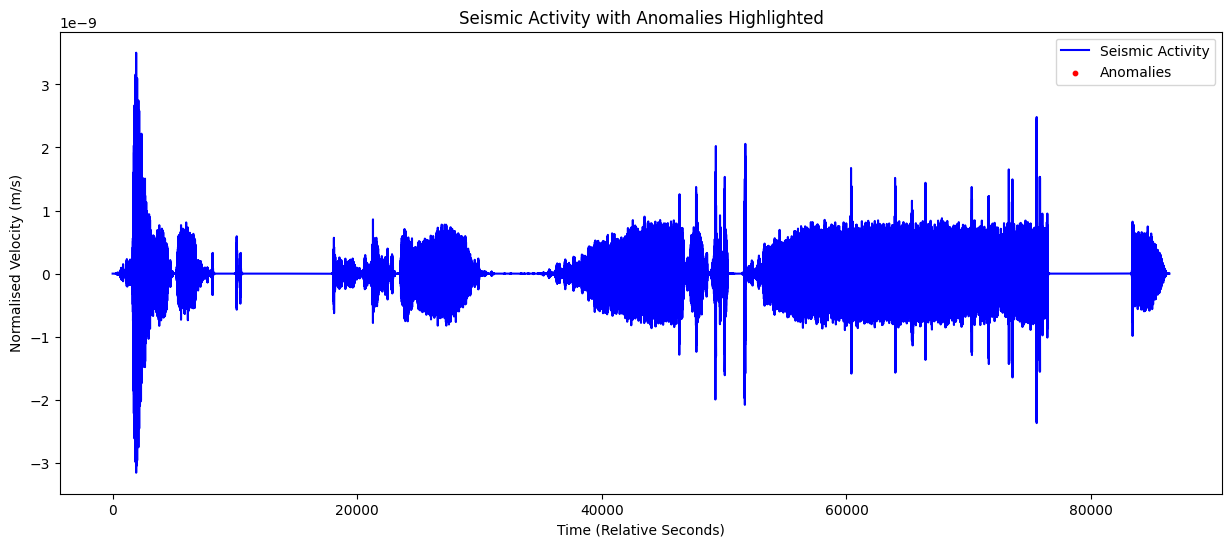

In [151]:
plt.figure(figsize=(15, 6))


plt.plot(
    time,
    X_standard,
    label="Seismic Activity",
    color="blue",
)

anomaly_indices = np.where(anomalies_label)[0]
plt.scatter(
    time[anomaly_indices + timesteps],
    X_standard[anomaly_indices + timesteps],
    color="red",
    label="Anomalies",
    marker="o",
    s=10,
    zorder=2,
)
print(len(anomaly_indices))

# arrival_line = plt.axvline(x=true_anomaly_time, c="red", label="Rel. Arrival")

plt.title("Seismic Activity with Anomalies Highlighted")
plt.xlabel("Time (Relative Seconds)")
plt.ylabel("Normalised Velocity (m/s)")
plt.legend()

plt.show()